In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit
from numba import jit
import numba as nb
from IPython.display import clear_output
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

In [2]:
@njit
def demand(p1t, p2t, p3t):
    if (p1t < p2t) and (p1t<p3t):
        return 1 - p1t
    elif (p1t == p2t == p3t):
        return 1/3 * (1 - p1t)
    elif (p1t > p2t) or (p1t > p3t):
        return 0
    elif ((p1t < p2t) and (p1t == p3t)) or ((p1t == p2t) and (p1t < p3t)):
        return 1/2 * (1 - p1t)
    
@njit
def profit(p1t, p2t, p3t):
    return p1t * demand(p1t, p2t, p3t)
    


In [3]:
@njit
def set_price(i, t, p_table, Q_table, prices, epsilon):
    
    if epsilon >= np.random.uniform(0,1):
        
        return np.random.choice(prices)
    else:
        if i == 0:
            j = 1
            k = 2
        if i == 1:
            j = 2
            k = 0
        if i == 2:
            j = 0
            k = 1
        s_t_idx = np.where(prices == p_table[j, t-1])[0][0] # our state (opponent's price)
        r_t_idx = np.where(prices == p_table[k, t-1])[0][0] # our other state (other opponent's price)
        
        maxedQ_idx = np.argmax(Q_table[r_t_idx, s_t_idx, :])
        return prices[maxedQ_idx]


In [4]:
#This set_price function is extended with the extra parameter r_next which it needs in order to pull the correct price
@njit
def set_price_ext(i, t, p_table, Q_table, prices, epsilon, r_next):
    
    if epsilon >= np.random.uniform(0,1):
        
        return np.random.choice(prices)
    else:
        if i == 0:
            j = 1
            k = 2
        if i == 1:
            j = 2
            k = 0
        if i == 2:
            j = 0
            k = 1
        s_t_idx = np.where(prices == p_table[j, t-1])[0][0] # our state (opponent's price)
        r_t_idx = np.where(prices == r_next)[0][0]
        
        maxedQ_idx = np.argmax(Q_table[r_t_idx, s_t_idx, :])
        return prices[maxedQ_idx]

In [5]:
@njit
def Q(p_it_idx, s_t_idx, r_t_idx, i, t, alpha, delta0, delta1, p_table, Q_table, prices, s_next, r_next) -> float: # p_table contains p and s (opponent price)
    if i == 0:
        j = 1
        k = 2
    if i == 1:
        j = 2
        k = 0
    if i == 2:
        j = 0
        k = 1

    prev_est = Q_table[r_t_idx, s_t_idx, p_it_idx]
    
    #s_next er s_{t+2} mens r_next er r_{t+1} som er blevet trukket fra set_price og set_price_ext. Disse skal bruges i new_est som estimater for hvilke priser firmaerne sætter i de næste perioder. 
    s_next_index = np.where(prices == s_next)[0][0]
    r_next_index = np.where(prices == r_next)[0][0]
    #Den maksimale Q-værdi om til tidspunkt t+2 givet priserne som vi forventer virksomhederne sætter i denne periode. 
    maxed_Q = max(Q_table[r_next_index, s_next_index, :])
    
    
    
    new_est = profit(p_table[i, t], p_table[j, t], p_table[k, t]) + (delta0 * profit(p_table[i, t], s_next, p_table[k, t+1])+ delta1**2 * profit(p_table[i, t], s_next, r_next))  + delta0**3 * maxed_Q

    
    return (1 - alpha) * prev_est + alpha * new_est

In [6]:
@njit
def curr_prof(p_table, profits, i, t):
    if i == 0:
        j = 1
        k = 2
    if i == 1:
        j = 2
        k = 0
    if i == 2:
        j = 0
        k = 1
    profits[i, t] = profit(p_table[i,t], p_table[j,t], p_table[k,t])
    return

In [7]:

@njit
def bertrand_simulation(alpha, delta0, delta1, T, prices):

    # array of possible prices firms can choose (in this case k=6)
    i = 0
    j = 1
    k = 2
    t = 0
    # calculate the decay parameter theta
    theta = -(1/1000000)**(1/T) + 1
    epsilon = (1 - theta)**t

    p = len(prices)
    Q_table1 = np.zeros((p, p, p)) # |P| x |S| matrix
    Q_table2 = np.zeros((p, p, p)) 
    Q_table3 = np.zeros((p, p, p)) 
    p_table = np.empty((3, T))
    p_table.fill(np.nan)
    profits = np.zeros((3, T))

    profitabilities0 = []
    profitabilities1 = []
    profitabilities2 = []
    
    p_table[i, :3] = np.random.choice(prices) # firm 0 sets price for periods t=0:2
    p_table[j, :3] = np.random.choice(prices) # firm 1 sets price for periods t=0:2
    p_table[k, :3] = np.random.choice(prices) # firm 2 sets price for periods t=0:2
    
    t = 3 # 3 periods have passed, so t = 3
    while t < T:

        if i == 0: # update firm 0
            # learning module
            p_it_idx = np.where(prices == p_table[i, t-3])[0][0]
            s_t_idx =  np.where(prices == p_table[j, t-3])[0][0]
            r_t_idx =  np.where(prices == p_table[k, t-3])[0][0]
            r_next = set_price(k, t, p_table, Q_table3, prices, epsilon)
            s_next = set_price_ext(j, t, p_table, Q_table2, prices, epsilon, r_next)
            Q_table1[r_t_idx, s_t_idx,p_it_idx] = Q(p_it_idx, s_t_idx,r_t_idx, i, t-3, alpha, delta0, delta1, p_table, Q_table1, prices, r_next, s_next)

            # action module
            p_table[i, t] = set_price(i, t, p_table, Q_table1, prices, epsilon)
            p_table[j, t] = p_table[j, t-1]
            p_table[k, t] = p_table[k, t-1]
            

        if i ==1: # update firm 1
            # learning module
            p_it_idx = np.where(prices == p_table[i, t-3])[0][0]
            s_t_idx =  np.where(prices == p_table[j, t-3])[0][0]
            r_t_idx =  np.where(prices == p_table[k, t-3])[0][0]
            
            r_next = set_price(k, t, p_table, Q_table1, prices, epsilon)
            s_next = set_price_ext(j, t, p_table, Q_table3, prices, epsilon, r_next)
            Q_table2[r_t_idx, s_t_idx,p_it_idx] = Q(p_it_idx, s_t_idx,r_t_idx, i, t-3, alpha, delta0, delta1, p_table, Q_table2, prices, r_next, s_next)

            # action module
            p_table[i, t] = set_price(i, t, p_table, Q_table2, prices, epsilon)
            p_table[j, t] = p_table[j, t-1]
            p_table[k, t] = p_table[k, t-1]


        if i ==2: # update firm 2
            # learning module
            p_it_idx = np.where(prices == p_table[i, t-3])[0][0]
            s_t_idx =  np.where(prices == p_table[j, t-3])[0][0]
            r_t_idx =  np.where(prices == p_table[k, t-3])[0][0]
            r_next = set_price(k, t, p_table, Q_table2, prices, epsilon)
            s_next = set_price_ext(j, t, p_table, Q_table1, prices, epsilon, r_next)
            Q_table3[r_t_idx, s_t_idx, p_it_idx] = Q(p_it_idx, s_t_idx,r_t_idx, i, t-3, alpha, delta0, delta1, p_table, Q_table3, prices, r_next, s_next)
            
            # action module
            p_table[i, t] = set_price(i, t, p_table, Q_table3, prices, epsilon)
            p_table[j, t] = p_table[j, t-1]
            p_table[k, t] = p_table[k, t-1]

        
        # write profits for firm 0, 1 and 2
        curr_prof(p_table, profits, 0, t)
        curr_prof(p_table, profits, 1, t)
        curr_prof(p_table, profits, 2, t)
        
        if t % 12500 == 0:
            # compute avg. of last 1000 profits for each firm
            profitability0 = np.sum(profits[0, (t-1000):t])/1000 
            profitability1 = np.sum(profits[1, (t-1000):t])/1000
            profitability2 = np.sum(profits[2, (t-1000):t])/1000
            
            profitabilities0.append(profitability0)
            profitabilities1.append(profitability1)
            profitabilities2.append(profitability2)
            
        
        # calculate new epsilon using decay parameter
        epsilon = (1 - theta)**t
        # Update variables
        tmp = i
        i = j
        j = k
        k = tmp
        t += 1
    return p_table, profitabilities0, profitabilities1, profitabilities2


In [8]:
# ##### UNCOMMENT FOR COMPLICITY
# # set parameters
# # optionally use a fixed seed
# 
# #@njit
# def complicityfunc():
#     alpha, delta = 0.3, 0.99  # values from Klein(2021)
#     # alpha = np.linspace(0.1,0.6,20)
#     # delta = np.linspace(0.6,0.99,20)
#     T = 500000
#     N = 100
#     jointprofitability=[]
#     complicity=[]
#     #jointprofitability=nb.typed.List.empty_list(nb.f8)
#     #complicity=nb.typed.List.empty_list(nb.f8)
#     for n in range(0, N):
#         #print(n)
#         
#         # alphachoice=np.random.choice(alpha)
#         # deltachoice=np.random.choice(delta)
#         p_table, profitabilities0, profitabilities1, profitabilities2 = bertrand_simulation(alpha, delta, T)
# 
#         complicity.append(((profitabilities0[-1]+profitabilities1[-1]+profitabilities2[-1])/3)/0.08333333333333333)
#         # if (((profitabilities0[-1]+profitabilities1[-1]+profitabilities2[-1])/3)/0.08333333333333333)>0.6:
#         #     print((((profitabilities0[-1]+profitabilities1[-1]+profitabilities2[-1])/3)/0.08333333333333333))
#         #     print(alphachoice)
#         #     print(deltachoice)
#         return complicity
# 

In [9]:
#### UNCOMMENT FOR COMPLICITY
# from matplotlib.ticker import PercentFormatter
# plt.hist(complicity, bins=[i/10 for i in range(0,11)],rwidth=0.8, weights=np.ones(len(complicity)) / len(complicity))
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.xlabel('$\Delta$')
# plt.ylabel('Frequency')
# plt.title('Distribution of complicity ($\Delta$) for 1000 runs 3 firms')
# plt.show()

In [10]:
# #####UNCOMMENT FOR PRICEPLOT
# alpha, delta = 0.3, 0.95  # values from Klein(2021)
# T = 500000
# N = 1
# for n in range(0, N):
#     p_table, avg_profs0, avg_profs1, avg_profs2 = bertrand_simulation(alpha, delta, T)
#     
#     fig, ax = plt.subplots(2)
#     
#     ax[0].plot(range(0,T), p_table[0,:], color='blue', label = 'prices firm 0')
#     ax[0].plot(range(0,T), p_table[1,:], color='red', label = 'prices firm 1')
#     ax[0].plot(range(0,T), p_table[2,:], color='yellow', label = 'prices firm 2')
#     ax[0].legend()
#     print("Prices",p_table[0,-1],p_table[1,-1],p_table[2,-1])
#     average_profitabilities = np.sum([avg_profs0, avg_profs1, avg_profs2], axis=0)/3
#     # print("average profitability:\n",average_avg_profs)
#     # ax[1].plot(np.linspace(0,T,19), average_profitabilities, color="purple", label = "avg. profitability")
#     # ax[1].legend()
#     
#     
# 
#     plt.legend()
#     plt.show()

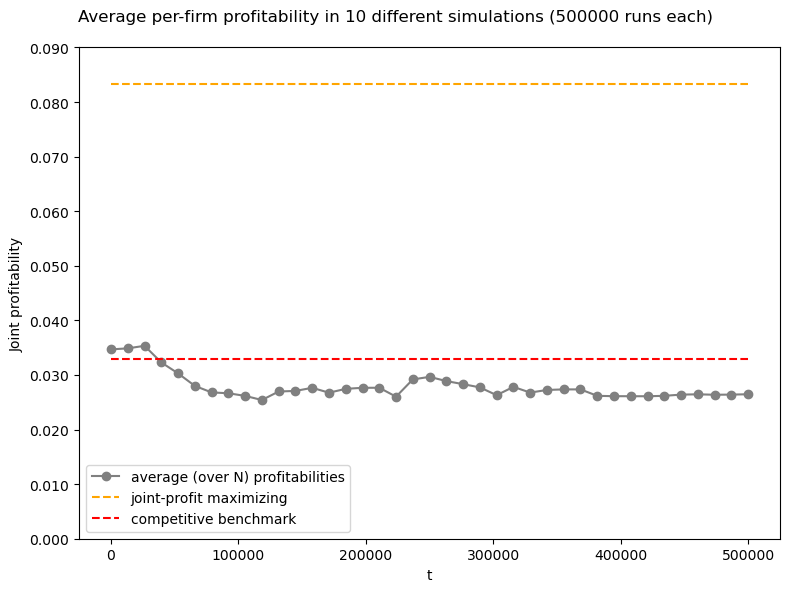

In [11]:
alpha, delta0, delta1 = 0.3, 0.5, 0.95  # values from Klein(2021)
T = 500000
N = 10
prices = np.linspace(0, 1, 49)
num_calcs = int(T/12500-1)
summed_avg_profitabilities = np.zeros(num_calcs)

for n in range(0, N):
    p_table, avg_profs1, avg_profs2, avg_profs3 = bertrand_simulation(alpha, delta0, delta1, T, prices)
    per_firm_profit = np.sum([avg_profs1, avg_profs2, avg_profs3], axis=0)/3
    summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
    
avg_avg_profitabilities = np.divide(summed_avg_profitabilities, N)
    
fig, axs = plt.subplots(1)
fig.suptitle("Average per-firm profitability in 10 different simulations (500000 runs each)")
fig.set_figheight(6)
fig.set_figwidth(8)
axs.set_xlabel("t")
axs.set_ylabel("Joint profitability")
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
axs.set_ylim(0.0, 0.09)
xs = np.linspace(0, T, num_calcs)
axs.plot(xs, avg_avg_profitabilities, color="grey", label = "average (over N) profitabilities", marker='o')
axs.plot(xs, [0.08333]*len(xs), color='orange', label='joint-profit maximizing', linestyle='dashed')
axs.plot(xs, [0.033]*len(xs), color='red', label='competitive benchmark', linestyle='dashed')
#axs.xaxis.set_major_locator(ticker.MultipleLocator(1))
axs.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
fig.tight_layout()
plt.legend()
plt.show()